# Overview

This workbook illustrates text clustering in Python (using mainly sklearn framework). 

The data consists of ~5k texts (web articles) with tech content, clustered in ~ 480 categories (the data file is attached as "data.csv"). The goal is to cluster these articles possibly close to the original labels provided.

While there is quite a lot web tutorials on text classification and clustering, this demo shows also presents some less common tricks.

The main finding is that the bag-of-words model (counting keywords frequencies) works pretty well when couppled with few tricks.
Ignoring stopwords and stemming terms helps to choose selective and non-redundant keywords.
Dimensionality-reduction techniques are necessary, because of too many keywords (a consequence of many clusters). Also, for better peformance, we combine knowledge extracted from titles and full texts in a non-symmetric way (weighted average of two modeles).

Interestingly, more advanced text-processing techniques (ngrams, lemmatization) and information-theoretic methods of selecting keywords (chi2 or entropy) don't seem to help. This is probably due to the specific content of articles - being related to modern technologies, they are likely to be classified better with single keywords than with phrases and other grammatical variations.

The presented solution achieves accuracy ~ 75.5% (as measured by ARI), when compared with the original labelling.

Achieving much better results may be more complicated because of highly inbalanced data - many clusters have just few members and are hard to learn.


# Python code

### Libraries

In [66]:
import string

import os
import pandas as pnd
import numpy as np
import sklearn
import math

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import metrics

import re
import nltk 
import spacy # note: make sure that spacy is installed properly!

from sklearn.decomposition import TruncatedSVD

from scipy.stats import entropy

import matplotlib.pyplot as plt

## Preprocessing

In [68]:
## DATA EXTRACTION ##

# ! set the proper path to the training data file 
data = pnd.read_csv('data.csv', header=0)

# grund truth - original labels will be used for evaluation
y_train = data['cid']
# training data
X_train = data.drop('cid',axis=1)
data.loc[:10]

,cid,title,text
0,0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
1,0,Samsung to Showcase Three Creative Lab Project...,Samsung Electronics announced that it will be ...
2,0,OrCam's MyMe wearable will watch and decode th...,You've probably heard of wearable cameras from...
3,0,It’s an Unobtrusive Assistant Whispering in Yo...,PhotoThe OrCam MyMe speaks to the user through...
4,0,Drones look set to take centre stage at CES 2016,Drones or unmanned aerial vehicles (UAVs) have...
5,0,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...
6,0,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k..."
7,0,What ever happened to last year's Best of CES ...,What happens in Vegas stays in Vegas -- and th...
8,0,CES 2016: What To Expect,The Earth has just about completed another orb...
9,0,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...


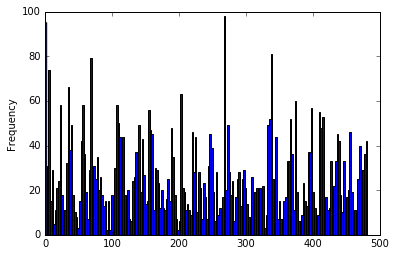

We have 322 classes of size >=5, which covers=92.16% of data


In [69]:
# Labels distribition - note it is highly inbalanced !

data['cid'].plot.hist(200)
plt.show()

min_class_size = 5
class_counts = pnd.crosstab(data['cid'],1)
print("We have %d classes of size >=%s, which covers=%s%% of data" % (np.float((class_counts>=min_class_size).sum()), min_class_size, 100*np.float( class_counts[class_counts>=min_class_size].sum()/len(data) )) )


## Simple model: Bag-of-words from title + KMeans clustering

In [70]:
## BAG-OF-WORDS MODEL ##

# create the term-document matrix, counting occurencies of words in documents!
count_vect = CountVectorizer(stop_words='english')
X_train_f = count_vect.fit_transform(X_train['title'])

# note the term-document matrix is sparse
print("sparse compression = %.4f" % ((X_train_f>0).sum()/(X_train_f.shape[0]*X_train_f.shape[1])))

sparse compression = 0.0013


In [71]:
# IDF transform reweight frequencies, to prefer more selective (=less common) terms

tfidf_transformer = TfidfTransformer().fit(X_train_f)
X_train_idf = tfidf_transformer.transform(X_train_f)

In [72]:
## KMeans Clustering ##

# the number of clusters known from the 'grund truth' labels
N = y_train.unique().shape[0]
clstr = KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1, n_jobs=-1)
clstr.fit(X_train_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=482, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Model Evaluation

In [73]:
## Evaluation

# compare with 'grund truth' labels; use information-theoretic metrics robust against the 'dimensionality curse'
def cluster_metrics(clstr):
    d = {}
    d["V-Measure"] = metrics.v_measure_score(y_train, clstr.labels_)
    d["Adjusted Rand Index"] =metrics.adjusted_rand_score(y_train, clstr.labels_)
    return d

cluster_metrics(clstr)

{'Adjusted Rand Index': 0.34037631930798512, 'V-Measure': 0.83695388295010942}

In [74]:
## Example - the first row cluster

labels = clstr.labels_
centers = clstr.cluster_centers_
features = np.array(count_vect.get_feature_names())
print("top keywords: %s"%",".join(features[centers[labels[0]].argsort()[-10:]]))
X_train[labels==labels[0]]
# makes sense, but far from perfect

top keywords: week,samsung,displays,tech,lenovo,look,best,expect,2016,ces


,title,text
0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
1,Samsung to Showcase Three Creative Lab Project...,Samsung Electronics announced that it will be ...
4,Drones look set to take centre stage at CES 2016,Drones or unmanned aerial vehicles (UAVs) have...
5,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...
7,What ever happened to last year's Best of CES ...,What happens in Vegas stays in Vegas -- and th...
8,CES 2016: What To Expect,The Earth has just about completed another orb...
9,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...
10,"A Glance at Highs, Lows of CES 2015",Consumer Electronics Show (CES) has markedly c...
11,The DeanBeat: Our preview of next week’s CES 2...,I made my predictions last week about what wil...
12,What to expect from CES in 2016,In just a few days the Engadget team will be g...


## Extensions and optimization

### Clustering on full texts

In [82]:
# use the 'text' field 

clstr = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11)),
])

clstr.fit(X_train['text'])

print(cluster_metrics(clstr.steps[2][1]))
# ari ~ 59.8%, much better! but the term-document matrix is still huge (too many keywords)
print("Words used: %s"%len(clstr.steps[0][1].vocabulary_))

{'Adjusted Rand Index': 0.59848939456267203, 'V-Measure': 0.90585739652935349}
Words used: 39024


In [83]:
def show_cluster(row, show_words=True, show_table=True):
    km =  clstr.steps[2][1]
    vect = clstr.steps[0][1]
    cid = km.labels_[row]
    centers = km.cluster_centers_
    features = np.array(vect.get_feature_names())
    if show_words:
        print("top keywords: %s"%",".join(features[centers[cid].argsort()[-20:]]))
    if show_table:
        return X_train[km.labels_==cid][['title','text']]
    else:
        return 

show_cluster(151)
# the cluster and keywords look more accurate, comparing to the previous attempt 

top keywords: their,attack,you,charney,mean,that,attacks,users,evidence,to,and,state,targeted,accounts,the,sponsored,your,compromised,account,microsoft


,title,text
151,Additional steps to help keep your personal in...,We’re committed to helping our users keep thei...
158,Microsoft will alert users of state-sponsored ...,"Microsoft is joining Google, Yahoo and Faceboo..."
159,Microsoft to Warn Users of State-Sponsored Att...,Microsoft on Wednesday announced plans to info...
160,Microsoft to Notify Users of State-Sponsored A...,Microsoft will now notify users if it believes...
161,Microsoft To Begin Warning Email Users Of Susp...,"With the announcement, the company will take t..."
162,Microsoft to Inform Users of Government Spying,Microsoft Corporation assured users that it is...
163,Microsoft pledges to inform users of state sur...,Microsoft has pledged to inform users if their...
171,Microsoft to Alert Users to Suspected Governme...,Microsoft Corp. said it plans to begin informi...
173,Microsoft will now alert you if your account i...,Microsoft has announced on the official compan...
174,Microsoft to alert users if their account gets...,"Last night, Microsoft announced the company wi..."


### Ignore very rare terms (feature selection)

In [84]:
# idea: skip terms with very low frequencies (e.g. <5), this makes the matrix smaller and speeds up computations

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5)),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11))
])

clstr.fit_transform(X_train['text'])

print("results: %s "%cluster_metrics(clstr.steps[2][1]))
print("words used: %s"%len(clstr.steps[0][1].vocabulary_))
# ari ~ 62%, much better and the term-document matrix is smaller - but have weak and redundant keywords

show_cluster(151)

results: {'Adjusted Rand Index': 0.62058820681783111, 'V-Measure': 0.90827451425414363} 
words used: 13945
top keywords: government,we,their,of,users,your,evidence,targeted,that,compromised,charney,and,sponsored,state,accounts,to,attacks,account,the,microsoft


,title,text
151,Additional steps to help keep your personal in...,We’re committed to helping our users keep thei...
157,Microsoft will notify users of suspected gover...,Microsoft said Wednesday night that it will te...
159,Microsoft to Warn Users of State-Sponsored Att...,Microsoft on Wednesday announced plans to info...
160,Microsoft to Notify Users of State-Sponsored A...,Microsoft will now notify users if it believes...
162,Microsoft to Inform Users of Government Spying,Microsoft Corporation assured users that it is...
163,Microsoft pledges to inform users of state sur...,Microsoft has pledged to inform users if their...
166,Microsoft to Warn Users of Governmental Hacks,Microsoft on Thursday announced that it will a...
167,Microsoft to warn of nation-state hacks,Users will be alerted if evidence suggests nat...
168,Microsoft will warn users targeted by governme...,Microsoft promises to notify its users if it b...
170,Microsoft to warn users if government might be...,If Microsoft thinks that intelligence agencies...


### Stopwords, Stemming (token-level analysis)

In [85]:
# we shall remove english stopwords like their, your... they are not informative as keywords

clstr.set_params(vect__stop_words='english')

clstr.fit(X_train['text'])

print("results: %s"%cluster_metrics(clstr.steps[2][1]))
print("words used: %s"%len(clstr.steps[0][1].vocabulary_))
show_cluster(151,show_table=False)
# ari ~ 63.6%, better! still, we have redundant keywords

results: {'Adjusted Rand Index': 0.63570712104373894, 'V-Measure': 0.91362455588378289}
words used: 13653
top keywords: attacker,notifications,attack,notify,password,suspicious,charney,malware,secure,evidence,attacks,mean,users,state,sponsored,targeted,accounts,compromised,account,microsoft


In [87]:
# stemming converts (heuristically) words to root forms - removing redundancy ("attack,attacks,attacker -> attack")

# assume documents are in english, keywords are alpha-numeric words of length 2 

# we try different algorithms, this may take a while
stemmers = [nltk.stem.PorterStemmer(),nltk.stem.SnowballStemmer('english'),nltk.stem.LancasterStemmer()]
stemmer_name = ['Porter','Snowballl','Lancaster']

pattern = re.compile( r'(?u)\b\w\w+\b' )

for i in range(len(stemmers)):

    stemmer = stemmers[i]
    
    def tokenize(text):
        # custom tokenize function
        text = text.translate(string.punctuation)
        tokens = pattern.findall(text)
        tokens_filtered = [stemmer.stem(t) for t in tokens]
        return tokens_filtered

    clstr.set_params(vect__tokenizer=tokenize)
    clstr.set_params(vect__strip_accents='unicode')
    
    clstr.fit(X_train['text'])
    # report 
    print('algorithm =%s  words used =%s  accuracy =%s'%(stemmer_name[i],len(clstr.steps[0][1].vocabulary_),
          cluster_metrics(clstr.steps[2][1])))
    
# ari up to ~ 65.8% and the vocabulary reduced! 

# note that smaller (less noisy?) vocabulares yield better results - looks like Lancaster wins!

vocabulary = list(clstr.steps[0][1].vocabulary_.keys()) # keep the last (best!) vocabulary for future use

Porter words used=9144 accuracy={'Adjusted Rand Index': 0.64018578543530236, 'V-Measure': 0.91489743536040546}
Snowballl words used=9048 accuracy={'Adjusted Rand Index': 0.64721972876425726, 'V-Measure': 0.91388384359105634}
Lancaster words used=7919 accuracy={'Adjusted Rand Index': 0.65763812045993653, 'V-Measure': 0.91584631853523402}


In [88]:
# example: note that redundant keywords disappeared

show_cluster(151)

top keywords: inform,suspicy,malw,tak,charney,mean,evid,stat,password,step,email,target,hack,spons,sec,comprom,yo,attack,microsoft,account


,title,text
151,Additional steps to help keep your personal in...,We’re committed to helping our users keep thei...
159,Microsoft to Warn Users of State-Sponsored Att...,Microsoft on Wednesday announced plans to info...
161,Microsoft To Begin Warning Email Users Of Susp...,"With the announcement, the company will take t..."
162,Microsoft to Inform Users of Government Spying,Microsoft Corporation assured users that it is...
163,Microsoft pledges to inform users of state sur...,Microsoft has pledged to inform users if their...
170,Microsoft to warn users if government might be...,If Microsoft thinks that intelligence agencies...
173,Microsoft will now alert you if your account i...,Microsoft has announced on the official compan...
174,Microsoft to alert users if their account gets...,"Last night, Microsoft announced the company wi..."
175,Microsoft to warn email users of possible stat...,As part of its movement towards better securit...
177,Microsoft to warn users of 'state-sponsored' h...,Microsoft has announced that it will be inform...


In [89]:
# we can use the precomputed vocabulary, this makes computations faster

clstr = Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,strip_accents='unicode',vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11))
])

clstr.fit_transform(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))

{'Adjusted Rand Index': 0.65763812045993653, 'V-Measure': 0.91584631853523402}


### Lemmatization, NGrams (more token-level analysis)

In [ ]:
# one can form tokens from "n" consecutive words - so called n-grams, which is more likely to catch phrases

# note: it may take long!

clstr.set_params(vect__ngram_range=(1,2))
clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
# but it didn't help :-( probably, phrases are not that selective for tech-content, as single words

In [ ]:
# another interesting trick is to do lemmatizing - which is a deeper (grammar-aware) analysis of words 

# note: it may take long!

lemmatizer = spacy.load("en")

def lemmatize(text):
   	# custom tokenize function
    text = text.translate(string.punctuation)
    tokens = pattern.findall(text)
    lemmas = lemmatizer(text)
    tokens_filtered = [t.lemma_ for t in lemmas]
    return tokens_filtered

print(lemmatize("It's going better and better")) # example

clstr.set_params(vect__ngram_range=(1,1))
clstr.set_params(vect__tokenizer=lemmatize)
clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
# but it didn't help :-( probably most selective keywords are nouns, and linguistic games are not necessary
clstr = clstr.set_params(vect__tokenizer=tokenize)

### Concatenate titles and texts (feature ingeneering)

In [90]:
# we shall use both text and titles (titles may contain our keywords). 

# to demonstrate it works we concatenate, later we will combine them in a different way

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5,stop_words='english')),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11))
])

X_train['alltext'] = X_train['text']+X_train['title']
clstr.fit(X_train['alltext'])
print(cluster_metrics(clstr.steps[2][1]))
# ari ~ 65.1% which is (given the parameters above) better than for text only (we got 63.6%)! 

{'Adjusted Rand Index': 0.65101723036386638, 'V-Measure': 0.91949566978819963}


### Words preselection (feature selection)

In [93]:
# idea: select terms most informative about the class distribution (ground truth labels) 
# to evaluate information gain, use information-theoretic metrics like mutual information or chi2

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5,stop_words = 'english')),
            ('tfidf', TfidfTransformer()),
            ('feature_select',SelectKBest(chi2,k=5000)),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1, n_jobs = -1, random_state=11)),
])

clstr.fit(X_train['text'],y_train)
print(cluster_metrics(clstr.steps[3][1]))

# didn't work well :-( 
# a) the approach is greedy and may select many correlated attributes that maximize information
# b) we have many classes and don't expect to massively reduce the number of keywords involved

{'Adjusted Rand Index': 0.41135571087816902, 'V-Measure': 0.89274849054885808}


### Latent Semantic Analysis (dimension reduction)

In [94]:
# idea: approximate data by a linear low-dimensional object (by means of Singular Value Decomposition). 
# note: for text clusteting one typically uses 100-200 dimensions
# note: all feetures may contribute to this transformation, as opposed to feature preselection

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5, stop_words = 'english')),
            ('tfidf', TfidfTransformer()),
            ('svd', TruncatedSVD(random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1, n_jobs = -1, random_state=11)),
])
# tunning the svd dimension 
for dim in [100,150,200,250]:
    clstr.set_params(svd__n_components=dim)
    clstr.fit(X_train['text'])
    print("n_dimensions=%s,results=%s"%(dim,cluster_metrics(clstr.steps[4][1])))

# ari ~ 70.3%, improved :-)

n_dimensions=100,results={'Adjusted Rand Index': 0.66553497838887543, 'V-Measure': 0.91381604330571742}
n_dimensions=150,results={'Adjusted Rand Index': 0.68679826644428787, 'V-Measure': 0.92076921209944718}
n_dimensions=200,results={'Adjusted Rand Index': 0.70252954856867411, 'V-Measure': 0.92424160319266113}
n_dimensions=250,results={'Adjusted Rand Index': 0.68698731032201699, 'V-Measure': 0.92417012450216673}


### Hierarchical Clustering Algorithm

In [96]:
# AgglomerativeClustering merges cluster iteratively (aka rich gets richer)

# here we utilize all previous optimization tricks

clstr = Pipeline([
            ('vect', CountVectorizer(strip_accents='unicode',tokenizer=tokenize, vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer()),
            ('svd', TruncatedSVD(n_components=150, random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr',AgglomerativeClustering(n_clusters=N,linkage='ward'))
])
clstr.fit(X_train['text'])
print("results=%s"%(cluster_metrics(clstr.steps[4][1])))
# ari ~ 72.5%, improved :-) 

results={'Adjusted Rand Index': 0.72515077205632006, 'V-Measure': 0.92792979499367889}


In [97]:
# illustrate the results - show the cluster of the first row
labels = clstr.steps[4][1].labels_
X_train[labels==labels[0]][['title','text']]

,title,text
0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
6,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k..."
8,CES 2016: What To Expect,The Earth has just about completed another orb...
10,"A Glance at Highs, Lows of CES 2015",Consumer Electronics Show (CES) has markedly c...
11,The DeanBeat: Our preview of next week’s CES 2...,I made my predictions last week about what wil...
12,What to expect from CES in 2016,In just a few days the Engadget team will be g...
13,What to Look for at CES 2016,"Not too many years ago, the primary focal poin..."
14,CES 2016: What to expect from the Las Vegas te...,"Ready or not, the annual Consumer Electronics ..."
15,CES 2016 guide: How to survive the madness,Surviving the Consumer Electronics Show is no ...
17,What to expect at CES 2017,"Now simply known as CES, not the Consumer Elec..."


In [ ]:
# test the performance when clustering on all text data
clstr.fit(X_train['alltext'])
print("results=%s"%(cluster_metrics(clstr.steps[4][1])))
# ari ~ 73.2%, better :-) 

### Similarity Metrics (connectivity constraints)

In [98]:
# cosine distance is an effective similarity measure of (vectorized representations of) documents

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5, stop_words='english',vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer())
])
X_train_idf = clstr.fit_transform(X_train['text'])
dist = 1 - metrics.pairwise.cosine_similarity(X_train_idf)
# see top 20 documents related to the first row
X_train.loc[sorted( dist[0,:].argsort()[:20] )]

,title,text,alltext
0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...,We are on the eve of the year's biggest techno...
5,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...,The start of 2016 means start of the biggest t...
6,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k...","The International Consumer Electronics Show, k..."
7,What ever happened to last year's Best of CES ...,What happens in Vegas stays in Vegas -- and th...,What happens in Vegas stays in Vegas -- and th...
8,CES 2016: What To Expect,The Earth has just about completed another orb...,The Earth has just about completed another orb...
9,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...,I've gone to Las Vegas for CES every January s...
10,"A Glance at Highs, Lows of CES 2015",Consumer Electronics Show (CES) has markedly c...,Consumer Electronics Show (CES) has markedly c...
11,The DeanBeat: Our preview of next week’s CES 2...,I made my predictions last week about what wil...,I made my predictions last week about what wil...
12,What to expect from CES in 2016,In just a few days the Engadget team will be g...,In just a few days the Engadget team will be g...
13,What to Look for at CES 2016,"Not too many years ago, the primary focal poin...","Not too many years ago, the primary focal poin..."


In [99]:
# we can use it to put "connectivity" constraints on the clustered data, e.g. only "close" points can be clustered

# define which points may be  related (boolean matrix)

connectivity = dist < 0.9

clstr = Pipeline([
            ('svd', TruncatedSVD(n_components=150, random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr',AgglomerativeClustering(n_clusters=N,linkage='ward'))
])
clstr.fit(X_train_idf)
print("results=%s"%(cluster_metrics(clstr.steps[2][1])))

# this is to illustrate the technique only, it seems it doesn't help in our case

results={'Adjusted Rand Index': 0.64519488085387411, 'V-Measure': 0.90426609926264745}


### Weighted title+text model (feature engineering)

In [ ]:
# build separate models for text and title, and average by weights

clstr = Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,strip_accents='unicode',vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer())
])

# common vocabulary ensures the number of features is the sane for both models
X_train_idf1 = clstr.fit_transform(X_train['text'])
X_train_idf2 = clstr.transform(X_train['title'])

X_train_idf = 2*X_train_idf1 + 1*X_train_idf2 # text gets bigger weights !

clstr = Pipeline([
           	('svd', TruncatedSVD(n_components=200, random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr',AgglomerativeClustering(n_clusters=N,linkage='ward'))
])
clstr.fit(X_train_idf)
print("results=%s"%(cluster_metrics(clstr.steps[2][1])))
# ari ~ 75.5%, improved :-)


In [146]:
# illustrate the results - show the cluster about internet security issues
labels = clstr.steps[2][1].labels_
X_train[labels==labels[151]][['title','text']]

,title,text
151,Additional steps to help keep your personal in...,We’re committed to helping our users keep thei...
155,Microsoft To Notify If Government is Trying to...,Microsoft will now be informing users of any s...
158,Microsoft will alert users of state-sponsored ...,"Microsoft is joining Google, Yahoo and Faceboo..."
159,Microsoft to Warn Users of State-Sponsored Att...,Microsoft on Wednesday announced plans to info...
160,Microsoft to Notify Users of State-Sponsored A...,Microsoft will now notify users if it believes...
162,Microsoft to Inform Users of Government Spying,Microsoft Corporation assured users that it is...
171,Microsoft to Alert Users to Suspected Governme...,Microsoft Corp. said it plans to begin informi...
173,Microsoft will now alert you if your account i...,Microsoft has announced on the official compan...
174,Microsoft to alert users if their account gets...,"Last night, Microsoft announced the company wi..."
175,Microsoft to warn email users of possible stat...,As part of its movement towards better securit...


### Number of clusters

In [143]:
# we can try do slightly better by tweaking the number of clusters

clstr.set_params(clstr__n_clusters=450)
clstr.fit(X_train_idf)
print("results=%s"%(cluster_metrics(clstr.steps[2][1])))
# ari score ~ 75.1%, didn't help

results={'Adjusted Rand Index': 0.75062488149048956, 'V-Measure': 0.93603454384078266}


# Finall Clustering

In [ ]:
# compact code

N = 400  # set the number of clusters manually  
stemmer = nltk.stem.LancasterStemmer()  # choose stemming algorithm 

def preprocess(dt):
    # ignores article ids and maps class ids to numbers
    dt = dt.drop('aid',axis=1)
    cids = dt['cid'].unique()
    cids_range = len(cids) 
    cids_dict = {k:v for k,v in zip(cids,range(len(cids)))}
    dt['cid'] = dt['cid'].apply(lambda t: cids_dict[t])
    return dt

def best_tokenize(text):
    """" custom tokenize function """
    text = text.translate(string.punctuation)
    tokens = pattern.findall(text)
    tokens_filtered = [stemmer.stem(t) for t in tokens]
    return tokens_filtered

def cluster(file_path='techmeme-5k.csv'):
    """ change file_path to another file with the same csv structure """
    
    X = pnd.read_csv(file_path, header=0)
    X = preprocess(X)
    X = X.drop('cid',axis=1)

    clstr = Pipeline([
                ('vect', CountVectorizer(tokenizer=best_tokenize,strip_accents='unicode',stop_words='english',min_df=5)),
                ('tfidf', TfidfTransformer())
    ])
    X_idf1 = clstr.fit_transform(X_train['text'])
    # pass the vocabulary, so features are the same
    clstr.set_params(vect__vocabulary=clstr.steps[0][1].vocabulary_)
    X_idf2 = clstr.transform(X_train['title'])

    X_idf = 2*X_idf1 + 1*X_idf2  # text gets bigger weights !

    clstr = Pipeline([
                ('svd', TruncatedSVD(n_components=200, random_state=11)),     
                ('normalizer', Normalizer()),
                ('clstr',AgglomerativeClustering(n_clusters=N,linkage='ward'))
    ])
    clstr.fit(X_idf)
    print(cluster_metrics(clstr.steps[2][1]))
    return clstr.steps[2][1].labels_

In [ ]:
# test

cluster()